In [342]:
import numpy as np
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.offline as py
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 5
from plotly.graph_objs import *
from tqdm import tqdm
import statsmodels.api as sm
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, mean_absolute_error
import math
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [320]:
path = '/Users/torefossland/Documents/MAC0460/project/dataset/GlobalTemperatures.csv'

SELECTED = "AverageTemperature"

df = pd.read_csv(path)

#string to date format
df['Month'] = pd.to_datetime(df['dt'],infer_datetime_format=True)
df = df.set_index(['Month'])
df=df.dropna(axis=0)
df.rename(columns = {'LandAverageTemperature':'AverageTemperature', 'LandAverageTemperatureUncertainty':'AverageTemperatureUncertainty'}, inplace = True)

display(df)
series = df[SELECTED]
display(series)


,dt,AverageTemperature,AverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
Month,,,,,,,,,
1850-01-01,1850-01-01,0.749,1.105,8.242,1.738,-3.206,2.822,12.833,0.367
1850-02-01,1850-02-01,3.071,1.275,9.970,3.007,-2.291,1.623,13.588,0.414
1850-03-01,1850-03-01,4.954,0.955,10.347,2.401,-1.905,1.410,14.043,0.341
1850-04-01,1850-04-01,7.217,0.665,12.934,1.004,1.018,1.329,14.667,0.267
1850-05-01,1850-05-01,10.004,0.617,15.655,2.406,3.811,1.347,15.507,0.249
...,...,...,...,...,...,...,...,...,...
2015-08-01,2015-08-01,14.755,0.072,20.699,0.110,9.005,0.170,17.589,0.057
2015-09-01,2015-09-01,12.999,0.079,18.845,0.088,7.199,0.229,17.049,0.058
2015-10-01,2015-10-01,10.801,0.102,16.450,0.059,5.232,0.115,16.290,0.062


Month
1850-01-01     0.749
1850-02-01     3.071
1850-03-01     4.954
1850-04-01     7.217
1850-05-01    10.004
               ...  
2015-08-01    14.755
2015-09-01    12.999
2015-10-01    10.801
2015-11-01     7.433
2015-12-01     5.518
Name: AverageTemperature, Length: 1992, dtype: float64

In [321]:
#Extract the year from a date
years = np.unique(df['dt'].apply(lambda x: x[:4]))
mean_temp = []
mean_temp_uncertainty = []

for year in years:
    mean_temp.append(df[df['dt'].apply(
        lambda x: x[:4]) == year]['AverageTemperature'].mean())
    mean_temp_uncertainty.append(df[df['dt'].apply(
                lambda x: x[:4]) == year]['AverageTemperatureUncertainty'].mean())

In [322]:
def plotting_function(mean_temp, mean_temp_uncertainty, years):
    trace0 = go.Scatter(
        x = years, 
        y = np.array(mean_temp) + np.array(mean_temp_uncertainty),
        fill= None,
        mode='lines',
        name='Uncertainty top',
        line=dict(
            color='rgb(0, 255, 255)',
        )
    )
    trace1 = go.Scatter(
        x = years, 
        y = np.array(mean_temp) - np.array(mean_temp_uncertainty),
        fill='tonexty',
        mode='lines',
        name='Uncertainty bot',
        line=dict(
            color='rgb(0, 255, 255)',
        )
    )

    trace2 = go.Scatter(
        x = years, 
        y = mean_temp,
        name='Average Temperature',
        line=dict(
            color='rgb(199, 121, 093)',
        )
    )
    data = [trace0, trace1, trace2]

    layout = go.Layout(
        xaxis=dict(title='year'),
        yaxis=dict(title='Average Temperature, °C'),
        title='Average land temperature in world',
        showlegend = False)

    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)
    
plotting_function(mean_temp, mean_temp_uncertainty, years)

# There is a lot of uncertainty in the earlier data, so I pick out the last 150 years
mean_temp = mean_temp[-150:]
mean_temp_uncertainty = mean_temp_uncertainty[-150:]
years = years[-150:]
plotting_function(mean_temp, mean_temp_uncertainty, years)

In [323]:
data = {'Year': years,
        'Temperature': mean_temp}

new_df = pd.DataFrame(data)
display(new_df)

,Year,Temperature
0,1866,8.292167
1,1867,8.436333
2,1868,8.247917
3,1869,8.432083
4,1870,8.201333
...,...,...
145,2011,9.516000
146,2012,9.507333
147,2013,9.606500
148,2014,9.570667


           t-1       t+1
Year                    
1866       NaN  8.292167
1867  8.292167  8.436333
1868  8.436333  8.247917
1869  8.247917  8.432083
1870  8.432083  8.201333


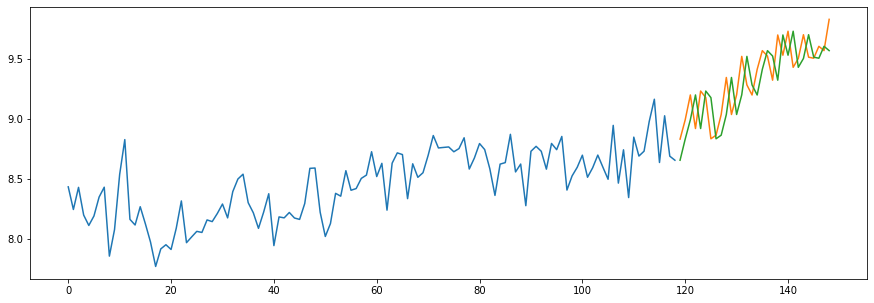

In [324]:
# https://machinelearningmastery.com/persistence-time-series-forecasting-with-python/
values = pd.DataFrame(new_df['Temperature'])
values = values.set_index(new_df['Year'])
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
print(dataframe.head(5))
 
# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.8)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
 
# persistence model
def model_persistence(x):
    return x
# walk-forward validation
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
    
# plot predictions and expected results
plt.plot(train_y)
plt.plot([None for i in train_y] + [x for x in test_y])
plt.plot([None for i in train_y] + [x for x in predictions])
plt.show()

In [348]:
#Loss functions
def evaluate_predictions(test, preds):
    rmse = np.sqrt(mean_squared_error(test, preds))
    msle = mean_squared_log_error(test, preds)
    mae = mean_absolute_error(test, preds)
    print('RMSE: ', rmse, "\t", 'MSLE: ', msle, "\t", 'MAE: ', mae)
    return rmse, msle, mae
    
evaluate_predictions(test_y, predictions)

RMSE:  0.2144702139813012 	 MSLE:  0.00043390601026991964 	 MAE:  0.18930555555555534


(0.2144702139813012, 0.00043390601026991964, 0.18930555555555534)

In [326]:
#split into test and train sets
split_ratio = 0.8
X = new_df.values
train_size = int(len(X) * split_ratio)
train, test = X[1:train_size+1], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

data = {'Year': train_X,
        'Temperature': train_y}
train_data = pd.DataFrame(data)

data = {'Year': test_X,
        'Temperature': test_y}
test_data = pd.DataFrame(data)

display(train_data.head())
display(test_data.head())

,Year,Temperature
0,1867,8.436333
1,1868,8.247917
2,1869,8.432083
3,1870,8.201333
4,1871,8.115083


,Year,Temperature
0,1986,8.833583
1,1987,8.994417
2,1988,9.201583
3,1989,8.922
4,1990,9.234167


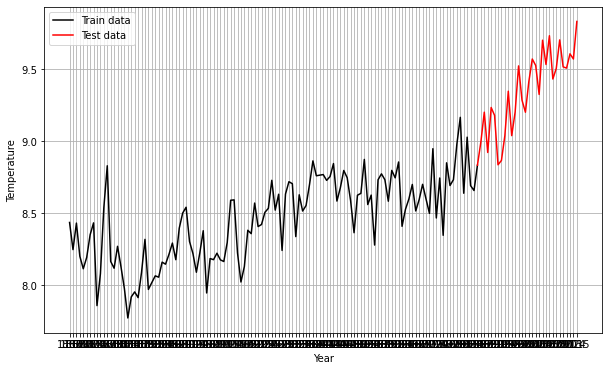

In [327]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.plot(train_X, train_y, 'black', label='Train data')
plt.plot(test_X, test_y, 'red', label='Test data')
plt.legend()

In [329]:
test_data['Year'] = pd.to_datetime(test_data['Year'],infer_datetime_format=True)
test_data = test_data.set_index(['Year'])
train_data['Year'] = pd.to_datetime(train_data['Year'],infer_datetime_format=True)
train_data = train_data.set_index(['Year'])
display(train_data.head())
display(test_data.head())

,Temperature
Year,
1867-01-01,8.436333
1868-01-01,8.247917
1869-01-01,8.432083
1870-01-01,8.201333
1871-01-01,8.115083


,Temperature
Year,
1986-01-01,8.833583
1987-01-01,8.994417
1988-01-01,9.201583
1989-01-01,8.922
1990-01-01,9.234167


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-20.185, Time=0.14 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=37.368, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=14.990, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-20.770, Time=0.12 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=9.381, Time=0.01 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-18.800, Time=0.16 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-18.806, Time=0.82 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-5.948, Time=0.06 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.77 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=14.227, Time=0.06 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=-20.240, Time=0.15 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-1.309, Time=0.10 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-18.250, Time=0.27 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=-19.129, Time=0.16 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]       

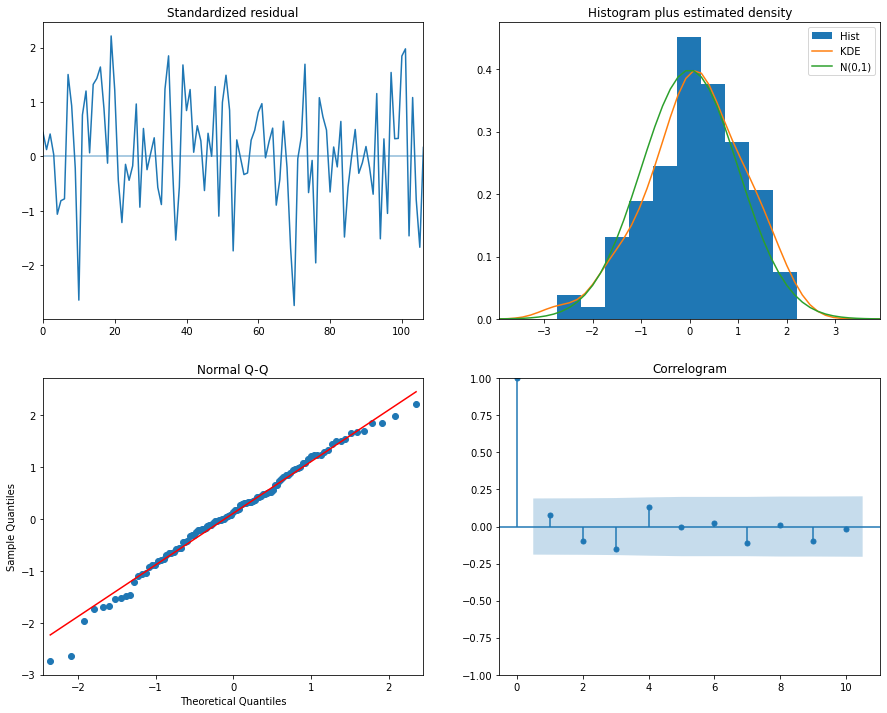

In [330]:
# Seasonal - fit stepwise auto-ARIMA
model = pm.auto_arima(train_data['Temperature'], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=12, #12 is the frequency of the cycle
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

model.plot_diagnostics(figsize=(15,12))
plt.show()

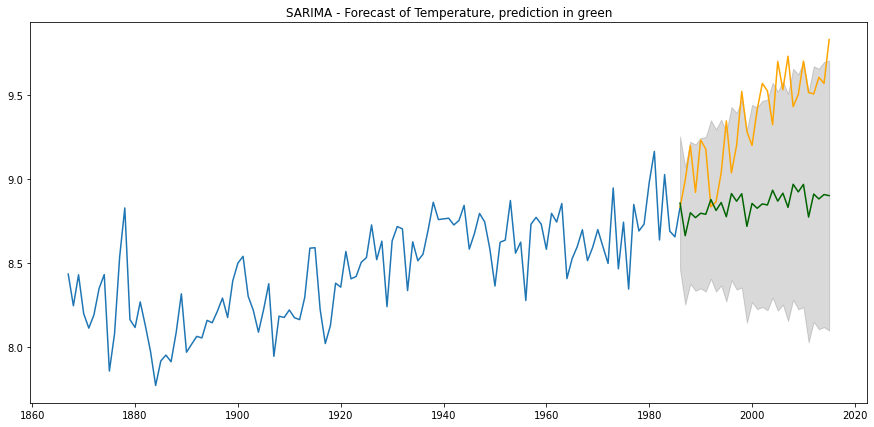

In [331]:
def forecast(ARIMA_model, periods):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods, return_conf_int=True)
    index_of_fc = test_data.index
    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)
    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(train_data['Temperature'], color='#1f76b4', label='Train data')
    plt.plot(test_data['Temperature'], color='orange', label='Test data')
    #plt.plot(new_df['Temperature'], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen', label='Forecast')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("SARIMA - Forecast of Temperature, prediction in green")
    plt.show()
    return fitted_series



fitted_series = forecast(SARIMA_model, len(test_data))



In [349]:
#Root mean squared Error
evaluate_predictions(test_data['Temperature'], fitted_series)

RMSE:  0.5503166161688134 	 MSLE:  0.002912029404832246 	 MAE:  0.4894897447753309


(0.5503166161688134, 0.002912029404832246, 0.4894897447753309)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=23.334, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=11.244, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.18 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=17.993, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5.360, Time=0.13 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=0.339, Time=0.45 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.26 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=2.172, Time=0.69 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=0.56 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=5.672, Time=0.38 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=0.92 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=inf, Time=0.69 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=0.66 sec
 ARIMA(2,1,1)(2,1,1)[12]             : AIC=inf, Time=1.05 sec
 ARIMA(1,1

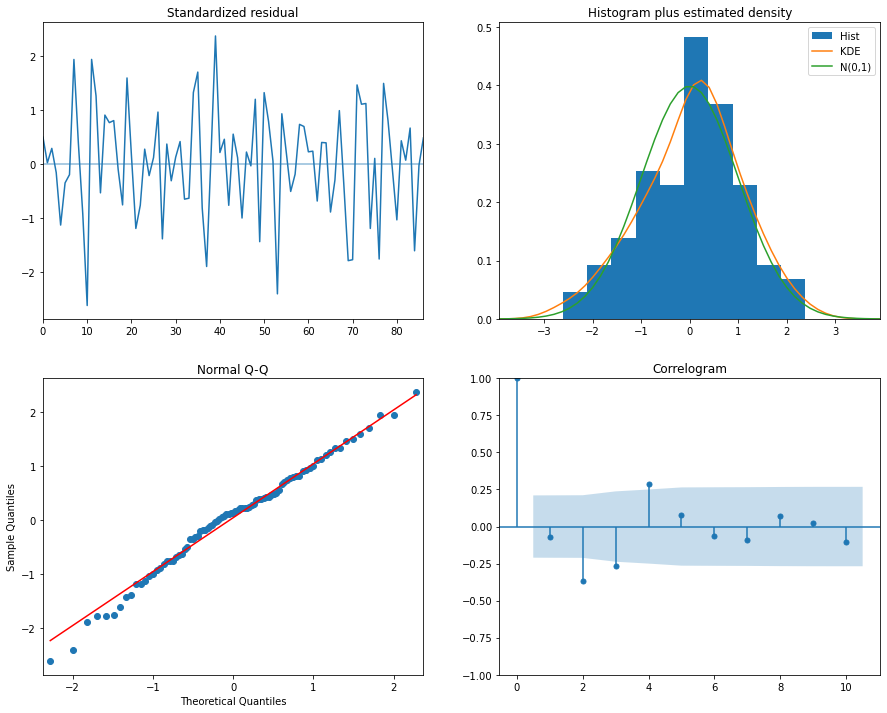

In [333]:
train_data_small = train_data.head(100)
SARIMA_model_small = pm.auto_arima(train_data_small['Temperature'], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=12, #12 is the frequency of the cycle
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

SARIMA_model_small.plot_diagnostics(figsize=(15,12))
plt.show()

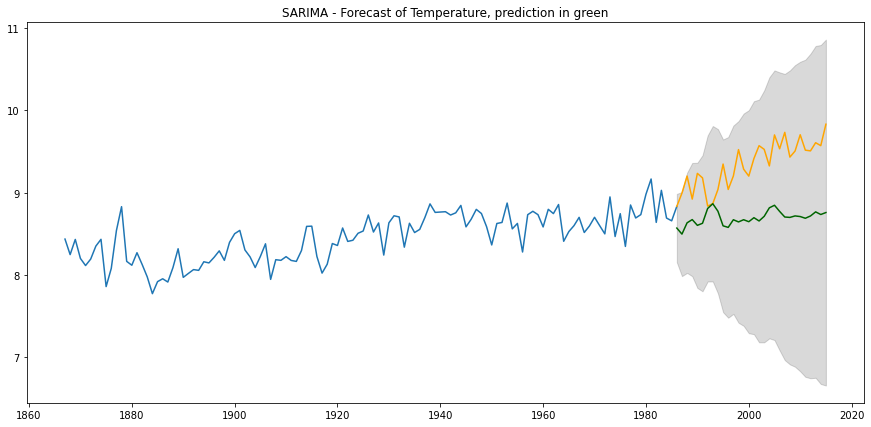

In [334]:
fitted_series_small = forecast(SARIMA_model_small, len(test_data))

In [351]:
evaluate_predictions(test_data['Temperature'], fitted_series_small)

RMSE:  0.6982203086506172 	 MSLE:  0.004782113218402038 	 MAE:  0.6438679449628898


(0.6982203086506172, 0.004782113218402038, 0.6438679449628898)

,Temperature
Year,
1867-01-01,7.612883
1868-01-01,4.996509
1869-01-01,9.778548
1870-01-01,7.78568
1871-01-01,8.993104


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=359.955, Time=0.23 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=453.105, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=391.788, Time=0.03 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=358.743, Time=0.07 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=395.908, Time=0.02 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.25 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=0.30 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=362.147, Time=0.05 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=361.920, Time=0.34 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=423.396, Time=0.04 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=359.857, Time=0.08 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=389.210, Time=0.06 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=361.829, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=360.461, Time=0.13 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]    

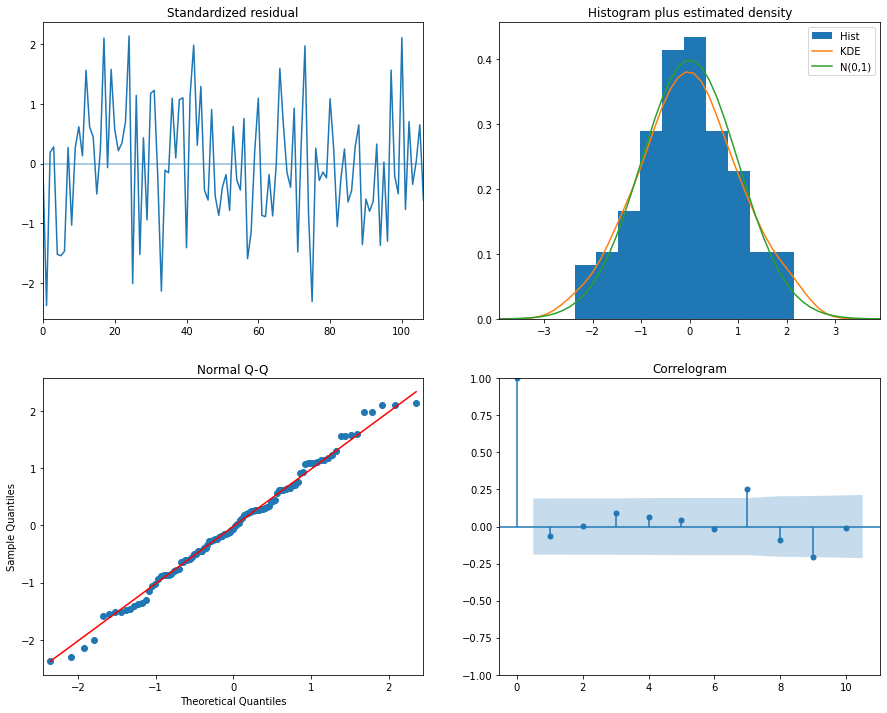

In [359]:
# Seasonal - fit stepwise auto-ARIMA
#Adding gaussian noise signal
mu, sigma = 0, 1
noise = np.random.normal(mu,sigma,len(train_data))
train_data_noise = train_data.copy()
train_data_noise['Temperature'] += noise
display(train_data_noise.head())

SARIMA_model_noise = pm.auto_arima(train_data_noise['Temperature'], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=12, #12 is the frequency of the cycle
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

SARIMA_model_noise.plot_diagnostics(figsize=(15,12))
plt.show()

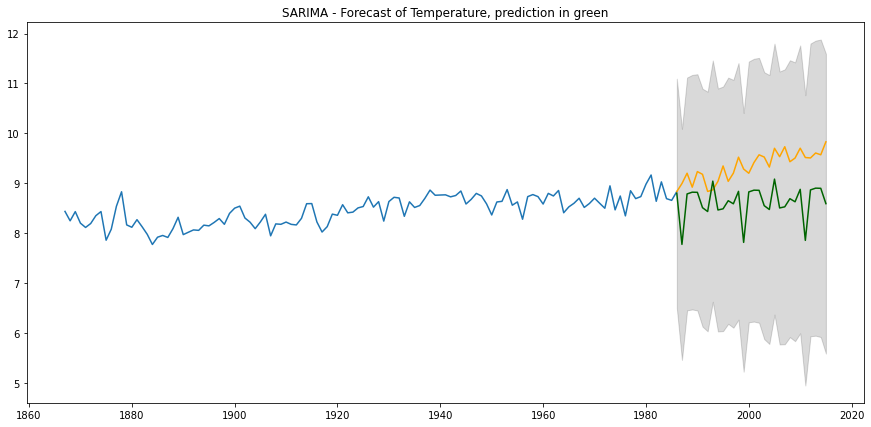

In [360]:
fitted_series_noise = forecast(SARIMA_model_noise, len(test_data))

In [361]:
evaluate_predictions(test_data['Temperature'], fitted_series_noise)

RMSE:  0.8134407023948799 	 MSLE:  0.006756583352768002 	 MAE:  0.7228848556089941


(0.8134407023948799, 0.006756583352768002, 0.7228848556089941)